## **Análise de Teste A/B** 

**Clara Álvares Camargo**  
Novembro/2024

## Teste A/B

### Descrição técnica

- **Nome do teste:** `recommender_system_test`
- **Grupos:** A (controle) B (funil de novos pagamentos)
- **Data de início:** 07-12-2020
- **Data de quando paparam de receber novos usuários:** 21-12-2020
- **Data de término:** 01-01-2021
- **Público:** 15% de novos usuários da região da UE
- **Propósito do teste:** testar mudanças relacionadas à introdução de uma recomendação do sistema melhorada
- **Resultado esperado:** em até 14 dias após o cadastro, usuários mostram uma conversão melhor nas visualizações de página do produto (o evento `product_page` event), ao adicionar itens ao carrinho (`product_cart`), e compras (`purchase`). A cada etapa do funil `product_page → product_cart → purchase`, terá ao menos 10% de aumento.
- **Número esperado de participantes do teste:** 6000

## 0. Bibliotecas

In [1]:
# importando bibliotecas
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import norm
import math
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

## 1. Dados

### 1.1. Descrição dos dados

1. **`ab_project_marketing_events_us.csv`**:  
o calendário de eventos de marketing para 2020  
  
2. **`final_ab_new_users_upd_us.csv`**:  
todos os usuários que se cadastraram na loja online de 7 a 21 de dezembro de 2020  
  
3. **`final_ab_events_upd_us.csv`**:  
todos os eventos dos novos usuários dentro do período de 7 de dezembro de 2020 até 1 de janeiro de 2021  
  
4. **`final_ab_participants_upd_us.csv`**:  
tabela contendo os participantes do teste

### 1.2. Leitura dos dados

In [2]:
# importando dados
mkt_events_raw = pd.read_csv('./ab_project_marketing_events_us.csv')

In [3]:
# importando dados
user_events_raw = pd.read_csv('./final_ab_events_upd_us.csv')

In [4]:
# importando dados
new_users_raw = pd.read_csv('./final_ab_new_users_upd_us.csv')

In [5]:
# importando dados
participants_raw = pd.read_csv('./final_ab_participants_upd_us.csv')

### 1.3. Tratamendo dos dados

#### 1.3.1. Marketing Events

In [6]:
# visualizando dados
mkt_events_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [7]:
# visualizando dados
mkt_events_raw

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [8]:
# convertendo tipo de dados colunas data
mkt_events_raw['start_dt'] = pd.to_datetime(mkt_events_raw['start_dt'])

In [9]:
# convertendo tipo de dados colunas data
mkt_events_raw['finish_dt'] = pd.to_datetime(mkt_events_raw['finish_dt'])

In [10]:
# visualizando dados
mkt_events_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


**Anotações:**  
  
Não há valores nulos ou duplicados.  
Tipos de dados: colunas 'start_dt' e 'finish_dt' - tipo de dados convertidos de 'object' para 'datetime'.

#### 1.3.2. User Events

In [11]:
# visualizando dados
user_events_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [12]:
# visualizando dados
user_events_raw.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [13]:
# visualizando dados
user_events_raw.tail()

,user_id,event_dt,event_name,details
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


In [14]:
# visualizando dados
user_events_raw.sample(10)

,user_id,event_dt,event_name,details
312614,4C1012A621B262D7,2020-12-16 03:55:39,login,NaN
53603,2B299A871D86A0E6,2020-12-24 07:22:58,purchase,9.99
116256,DE93A5022C8F38D3,2020-12-27 02:09:53,product_cart,NaN
329537,722863326D7345A4,2020-12-18 19:10:08,login,NaN
89358,DD9815DC748EA274,2020-12-18 09:42:16,product_cart,NaN
168136,10EBDD0CA85111D3,2020-12-16 18:14:50,product_page,NaN
364159,1A3F41B3784C4A22,2020-12-21 16:23:14,login,NaN
15951,183D7B2669777DF9,2020-12-14 22:24:20,purchase,9.99
70881,ACF26262F91EC715,2020-12-12 01:18:56,product_cart,NaN
17400,F93DC4A7DECAF9A9,2020-12-14 02:03:38,purchase,4.99


In [15]:
# conferindo se há linhas duplicadas
user_events_raw.duplicated().sum()

0

In [16]:
# convertendo tipo de dados coluna data
user_events_raw['event_dt'] = pd.to_datetime(user_events_raw['event_dt'])

In [17]:
# extraindo a data dos eventos
user_events_raw['event_date'] = user_events_raw['event_dt'].dt.date

In [18]:
# visualizando dados
user_events_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
 4   event_date  423761 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.2+ MB


**Anotações**:  
  
Valores ausentes: há valores ausentes apenas na coluna 'details', para as transações que não necessitam de informações adicionais. Estes campos foram mantidos como estão pois não afetam a análise.  
Tipos de dados: coluna 'event_dt' - tipo de dados convertidos de 'object' para 'datetime'.

#### 1.3.3. New Users 

In [19]:
# visualizando dados
new_users_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [20]:
# visualizando dados
new_users_raw.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [21]:
# visualizando dados
new_users_raw.tail()

,user_id,first_date,region,device
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone
58702,8F04273BB2860229,2020-12-20,EU,Android


In [22]:
# visualizando dados
new_users_raw.sample(10)

,user_id,first_date,region,device
38497,B3985C83D80548B8,2020-12-11,N.America,Android
21800,B7C7823313F3C351,2020-12-15,EU,iPhone
39612,7A8F6A62DD1FF192,2020-12-11,EU,Android
1297,458D5C4DF7512F81,2020-12-07,EU,Android
14801,25ECE9A69CDD38BB,2020-12-21,EU,Android
711,047DCD945FF14A33,2020-12-07,EU,PC
45270,6D863D292328C2F8,2020-12-12,CIS,Android
41944,3F0DE9FD92C5009B,2020-12-18,EU,iPhone
40884,944C88D5DF108AED,2020-12-18,EU,Android
45946,FB7410F4F4857D78,2020-12-12,N.America,Android


In [23]:
# convertendo tipo de dados coluna data
new_users_raw['first_date'] = pd.to_datetime(new_users_raw['first_date'])

In [24]:
# conferindo se há linhas duplicadas
new_users_raw.duplicated().sum()

0

In [25]:
# conferindo se há valores duplicados para 'user_id'
new_users_raw['user_id'].value_counts(ascending=False)

user_id
D72A72121175D8BE    1
87818F11DF867086    1
54053B51909746FA    1
6286DB850DAC4A39    1
39D8D335E253C151    1
                   ..
9212B9208445C44A    1
CD1F82589F1EA3F7    1
827B6C860070DF84    1
DA6EB5BBD34FFC82    1
8F04273BB2860229    1
Name: count, Length: 58703, dtype: int64

In [26]:
# visualizando dados
new_users_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


**Anotações:**  
  
Não há valores nulos ou duplicados.  
Tipos de dados: colunas 'first_date' - tipo de dados convertidos de 'object' para 'datetime'.

#### 1.3.4. Participants 

In [27]:
# visualizando dados
participants_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [28]:
# visualizando dados
participants_raw.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [29]:
# visualizando dados
participants_raw.tail()

,user_id,group,ab_test
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test
14524,79F9ABFB029CF724,B,interface_eu_test


In [30]:
# visualizando dados
participants_raw.sample(10)

,user_id,group,ab_test
597,74995B52B7D313F9,B,recommender_system_test
3440,5F09B85B875AA41D,A,recommender_system_test
14344,EC10F39FA1741B2B,A,interface_eu_test
4909,909F4EF02267D6A3,A,interface_eu_test
2525,04C99B9CE33D500A,B,recommender_system_test
5882,43EC96699454F65B,B,interface_eu_test
4649,243DD8C484CFB5B2,A,interface_eu_test
5702,0889C68B2417247C,A,interface_eu_test
14117,F75DF4FF552E43ED,A,interface_eu_test
13731,A5A1EA90094964D1,B,interface_eu_test


In [31]:
# conferindo se há linhas duplicadas
participants_raw.duplicated().sum()

0

In [32]:
# conferindo se há valores duplicados para 'user_id'
participants_raw['user_id'].value_counts(ascending=False)

user_id
307C06C0E6F09B93    2
74C5CCDA7DF761EE    2
6445624A3AE163E6    2
3A6D88AB973BD99D    2
C1E43A9B1D675927    2
                   ..
B39C1D7760CF809C    1
4E6C94A7969F5079    1
7EEEA8AA76EC8703    1
9EC259921F8521B1    1
79F9ABFB029CF724    1
Name: count, Length: 13638, dtype: int64

In [33]:
# contando as ocorrências de cada 'user_id'
user_counts = participants_raw['user_id'].value_counts()

# filtrando 'user_id' que aparecem mais de uma vez
user_duplicates = user_counts[user_counts > 1].index

# filtrando o DataFrame original para manter apenas as linhas com 'user_id' duplicados
df_duplicates = participants_raw[participants_raw['user_id'].isin(user_duplicates)]

In [34]:
# visualizando usuários duplicados
df_duplicates.head()

,user_id,group,ab_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
15,EAFB9027A27D510C,B,recommender_system_test
17,5D5E6EE92AF6E9E0,B,recommender_system_test


In [35]:
# contando número de usuários duplicados
df_duplicates['user_id'].nunique()

887

In [36]:
# visualizando linhas onde há usuários duplicados
df_duplicates[df_duplicates['user_id'] == 'DABC14FDDFADD29E']

,user_id,group,ab_test
2,DABC14FDDFADD29E,A,recommender_system_test
6703,DABC14FDDFADD29E,A,interface_eu_test


In [37]:
# visualizando linhas onde há usuários duplicados
df_duplicates[df_duplicates['user_id'] == '04988C5DF189632E']

,user_id,group,ab_test
3,04988C5DF189632E,A,recommender_system_test
10691,04988C5DF189632E,A,interface_eu_test


In [38]:
# visualizando linhas onde há usuários duplicados
df_duplicates[df_duplicates['user_id'] == '04988C5DF189632E']

,user_id,group,ab_test
3,04988C5DF189632E,A,recommender_system_test
10691,04988C5DF189632E,A,interface_eu_test


In [39]:
# verificando valores da coluna 'ab_test'
participants_raw['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [40]:
# contando número total de usuários que participaram de mais de um teste ab
df_duplicates['user_id'].nunique()

887

In [41]:
# filtrando DataFrame para usuários participantes do teste 'recommender_system_test'
participants_test = participants_raw[participants_raw['ab_test'] == 'recommender_system_test']

In [42]:
# contando número de usuários participantes do teste 'recommender_system_test'
participants_test.nunique()

user_id    3675
group         2
ab_test       1
dtype: int64

In [43]:
# calculando proporção dos usuários a serem filtrados
proportion = (df_duplicates['user_id'].nunique())/(participants_test['user_id'].nunique())

proportion

0.24136054421768707

**Anotações:**  
  
Verificou-se que 887 participantes participaram tanto do teste 'recommender_system_test' (objeto de análise deste exercício) quanto do teste 'interface_eu_test'.  
Se um mesmo usuário participa de dois testes ao mesmo tempo, ele pode ser exposto a diferentes variações que interferem nos resultados. Isso torna difícil isolar o impacto do sistema de recomendação melhorado, pois outros testes podem influenciar o comportamento do usuário.  
O número de usuários duplicados (887), corresponde a 0.24% do total de usuários participantes do teste (3675).

### 1.4. Filtragem dos dados

#### 1.4.1. Marketing Events

In [44]:
# filtrando DataFrame para eventos que incluam a região 'EU'
mkt_events_eu = mkt_events_raw[mkt_events_raw['regions'].str.contains('EU')]

In [45]:
# conferindo DataFrame após filtragem
mkt_events_eu['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'EU, CIS, APAC'],
      dtype=object)

**Anotações**:  
  
O DataFrame foi filtrado para incluir apenas eventos que incluam a região 'EU'.

#### 1.4.2. Participants

In [46]:
# DataFrame filtrado para usuários participantes do teste 'recommender_system_test'
participants_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3675 non-null   object
 1   group    3675 non-null   object
 2   ab_test  3675 non-null   object
dtypes: object(3)
memory usage: 114.8+ KB


In [47]:
# conferindo DataFrame filtrado
participants_test['ab_test'].unique()

array(['recommender_system_test'], dtype=object)

**Anotações**:  
  
O DataFrame foi filtrado para incluir apenas os partcipantes do teste a ser analisado: 'recommender_system_test'.

#### 1.4.3. New Users

In [48]:
# filtrando DataFrame para usuários da região 'EU'
new_users_eu = new_users_raw[new_users_raw['region'] == 'EU']

In [49]:
# conferindo DataFrame filtrado
new_users_eu['region'].unique()

array(['EU'], dtype=object)

**Anotações**:  
  
O DataFrame foi filtrado para incluir apenas usuários da região alvo do teste: 'EU'.

#### 1.4.4. User events

In [50]:
# listando usuários participantes do teste
participants_user_id = participants_test['user_id'].unique()

In [51]:
# filtrando DataFrame 'user_events' para incluir apenas eventos de usuários participantes do teste
user_events_filtered = user_events_raw[user_events_raw['user_id'].isin(participants_user_id)]

In [52]:
# conferindo filtrage dos usuários
# obtendo user_id únicos de cada DataFrame
unique_user_ids_user_events = set(user_events_filtered['user_id'].unique())
unique_user_ids_participants = set(participants_test['user_id'].unique())

# verificando se todos os user_id de user_events_filtered estão em participants_test
all_present = unique_user_ids_user_events.issubset(unique_user_ids_participants)
all_present

True

**Anotações**:  
  
O DataFrame de eventos por usuário foi filtrado para incluir apenas os eventos dos usuários participantes do teste.

#### 1.4.5. DataFrames finais 

In [53]:
# salvando DataFrames após tratamento e filtragem dos dados

mkt_events = mkt_events_eu
user_events = user_events_filtered
new_users = new_users_eu
participants = participants_test

### 1.5. EDA

#### 1.5.1. Conversão

In [54]:
# separando os eventos do funil
product_page_events = user_events[user_events['event_name'] == 'product_page']
product_cart_events = user_events[user_events['event_name'] == 'product_cart']
purchase_events = user_events[user_events['event_name'] == 'purchase']

In [55]:
# selecionando colunas do DataFrame 'participants'
participants = participants[['user_id', 'group']]

In [56]:
# calculando o número de usuários unívocos em cada etapa por grupo
product_page_users = product_page_events.merge(participants, on='user_id').groupby('group')['user_id'].nunique()
product_cart_users = product_cart_events.merge(participants, on='user_id').groupby('group')['user_id'].nunique()
purchase_users = purchase_events.merge(participants, on='user_id').groupby('group')['user_id'].nunique()

# calculndo o total de usuários em cada grupo para o cálculo das taxas de conversão
total_users = participants.groupby('group')['user_id'].nunique()

In [57]:
# calculando as taxas de conversão em cada etapa do funil
conversion_rates = pd.DataFrame({
    'Total Users': total_users,
    'Product Page Viewers': product_page_users,
    'Add to Cart': product_cart_users,
    'Purchasers': purchase_users
})

conversion_rates['Product Page Conversion'] = conversion_rates['Product Page Viewers'] / conversion_rates['Total Users']
conversion_rates['Add to Cart Conversion'] = conversion_rates['Add to Cart'] / conversion_rates['Product Page Viewers']
conversion_rates['Purchase Conversion'] = conversion_rates['Purchasers'] / conversion_rates['Add to Cart']

In [58]:
conversion_rates

,Total Users,Product Page Viewers,Add to Cart,Purchasers,Product Page Conversion,Add to Cart Conversion,Purchase Conversion
group,,,,,,,
A,2747,1780,824,872,0.647980,0.462921,1.058252
B,928,523,255,256,0.563578,0.487572,1.003922


In [59]:
# conferindo número de eventos por etapa do funil 
user_events_raw['event_name'].value_counts()

event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64

In [60]:
# definindo as colunas de conversão como lista de strings
conversion_columns = ['Product Page Conversion', 'Add to Cart Conversion', 'Purchase Conversion']

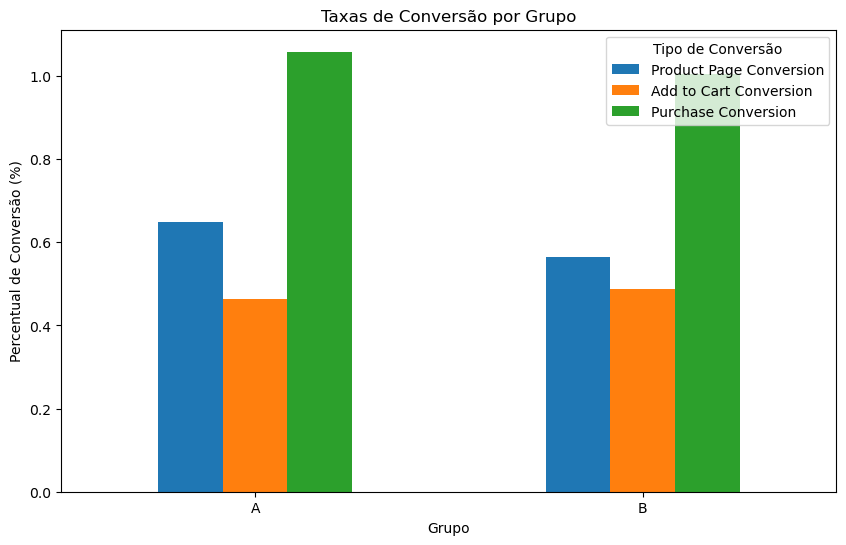

In [61]:
# plotando o gráfico de barras
conversion_rates[conversion_columns].plot(kind='bar', figsize=(10, 6))

plt.title('Taxas de Conversão por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Percentual de Conversão (%)')
plt.legend(title='Tipo de Conversão')
plt.xticks(rotation=0)
plt.show()

#### 1.5.2. Distribuição de eventos por usuário

In [62]:
# contando número de eventos por usuário
events_per_user = user_events.groupby('user_id').size().reset_index(name='events_count')

In [63]:
# mesclando DataFrame com os grupos dos participantes
events_per_user = events_per_user.merge(participants[['user_id', 'group']], on='user_id')

In [64]:
# calculando a média de eventos por grupo
events_by_group = events_per_user.groupby('group')['events_count'].mean()
events_by_group

group
A    6.780852
B    5.691810
Name: events_count, dtype: float64

In [65]:
# separando a contagem de eventos para cada grupo
events_group_a = events_per_user[events_per_user['group'] == 'A']['events_count']
events_group_b = events_per_user[events_per_user['group'] == 'B']['events_count']

In [66]:
# realizando teste de Mann-Whitney U para verificar se a diferença na média de eventos por usuário entre os grupos é estatisticamente significativa
stat, p_value = mannwhitneyu(events_group_a, events_group_b, alternative='two-sided')

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-value: {p_value}")


alpha = 0.05
if p_value < alpha:
    print("Há uma diferença estatisticamente significativa entre as médias dos grupos (rejeitamos H0).")
else:
    print("Não há diferença estatisticamente significativa entre as médias dos grupos (não rejeitamos H0).")

Mann-Whitney U Statistic: 1507455.0
P-value: 3.625922279604957e-17
Há uma diferença estatisticamente significativa entre as médias dos grupos (rejeitamos H0).


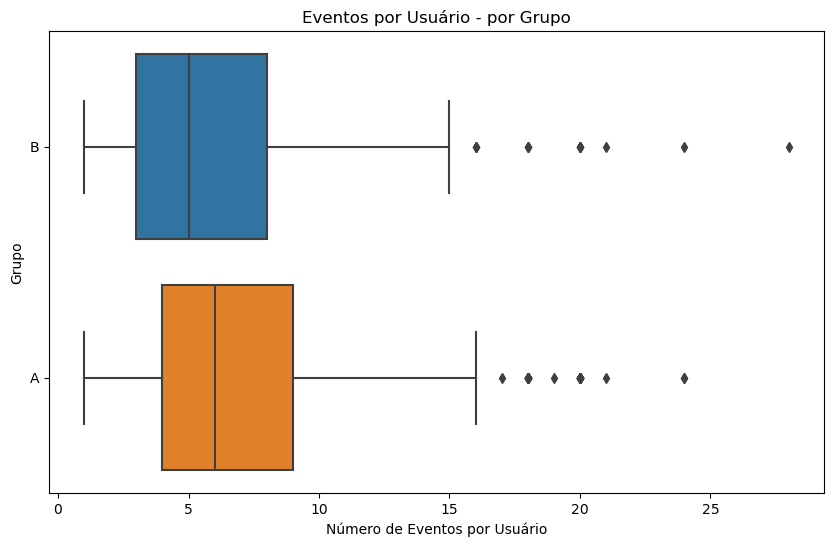

In [67]:
# imprimindo boxplot de eventos por usuário por grupo
plt.figure(figsize=(10, 6))
sns.boxplot(x="events_count", y="group", data=events_per_user, orient="h")
plt.title("Eventos por Usuário - por Grupo")
plt.xlabel("Número de Eventos por Usuário")
plt.ylabel("Grupo")
plt.show()

#### 1.5.3. Verificando participação dos usuários dos dois grupos

In [68]:
# verificando o número de usuários unívocos por grupo
participants.groupby('group').count()

,user_id
group,
A,2747
B,928


In [69]:
# verificando o número de usuários unívocos por grupo no DataFrame eventos
user_events = user_events.merge(participants[['user_id', 'group']], on='user_id')

In [70]:
# verificando o número de usuários unívocos por grupo participantes do teste
users_group = user_events.groupby('group')['user_id'].nunique()
users_group

group
A    2747
B     928
Name: user_id, dtype: int64

In [71]:
# calculando o total de participantes
total_participants = user_events['user_id'].nunique()
total_participants

3675

In [72]:
# calculando o percentual de cada grupo
group_proportion = (users_group / total_participants) * 100
group_proportion

group
A    74.748299
B    25.251701
Name: user_id, dtype: float64

**Anotações:**  
  
Do total de participantes do teste: 3675,  
74,75% pertencem ao grupo A e  
25,25% pertencem ao grupo B.  
  
Para que um teste de hipótese seja robusto, é ideal que os grupos sejam equilibrados, ou seja, cada grupo deveria ter uma amostra de tamanho semelhante. A grande diferença entre o número de usuários em cada grupo pode impactar a robustez e a confiabilidade do teste, levando a:  
Viés no resultado: Um grupo significativamente maior pode tornar o teste menos sensível a diferenças que ocorrem no grupo menor, distorcendo a interpretação do efeito do teste.  
Poder estatístico: A diferença de tamanho reduz o poder estatístico, especialmente no grupo menor, o que pode dificultar a identificação de diferenças reais entre os grupos.

#### 1.5.4. Distribuição de eventos por dia

In [73]:
# contando o número de eventos por data
events_per_day = user_events.groupby('event_date').size()

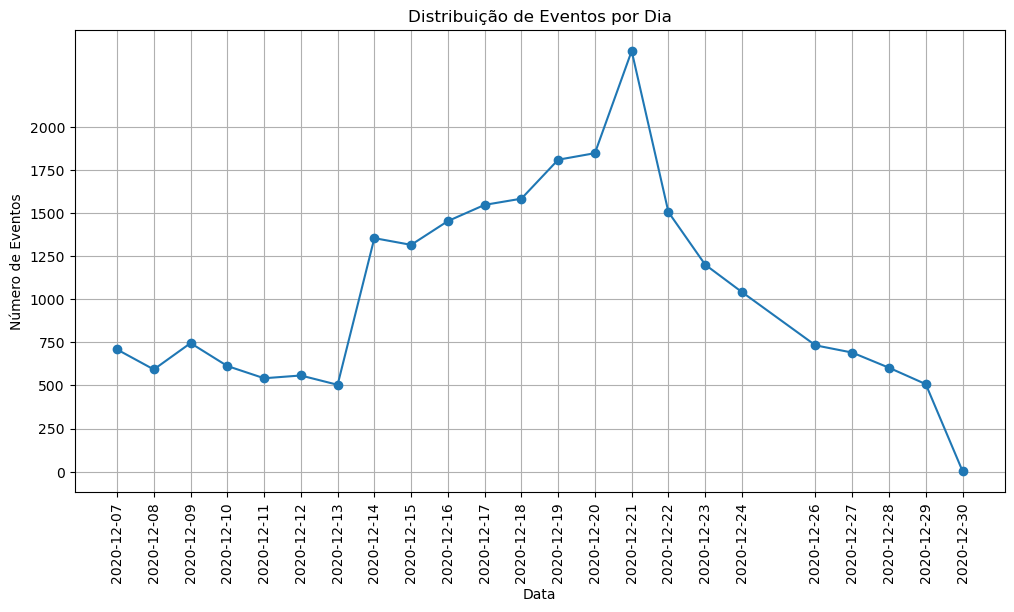

In [74]:
# visualizando a distribuição com um gráfico de linhas
plt.figure(figsize=(12, 6))
plt.plot(events_per_day.index, events_per_day.values, marker='o', linestyle='-')
plt.title("Distribuição de Eventos por Dia")
plt.xlabel("Data")
plt.ylabel("Número de Eventos")
plt.grid(True)
plt.xticks(events_per_day.index, rotation=90)
plt.yticks(range(0, 2001, 250))
plt.show()

**Anotações:**  
  
Distribuição de eventos por dia  
  
Tendência de Crescimento Inicial: Observa-se que a partir de 12 de dezembro de 2020, há um aumento notável no número de eventos diários. Esse crescimento se intensifica até atingir o pico em 20 de dezembro de 2020.  
Pico de Eventos: O dia 20 de dezembro de 2020 registra o maior número de eventos, com mais de 2000 ocorrências.  
Declínio Gradual Após o Pico: Após o pico em 20 de dezembro, há uma queda acentuada no número de eventos, que se torna mais constante e continua até o final do mês, em 30 de dezembro de 2020.  
Estabilização e Finalização do Período de Alta: A redução gradual ao longo dos últimos dias do período analisado sugere uma fase de estabilização, com os níveis de interação voltando aos patamares próximos dos observados no início do mês.  


#### 1.5.5. Verificando período do teste

In [75]:
# verificando valores mínimo e máximo para o campo 'event_date'
print(user_events['event_date'].min())
print(user_events['event_date'].max())

2020-12-07
2020-12-30


#### 1.5.6. Receita por Usuário

In [76]:
# filtrando DataFrame apenas com 'purchases'
user_purchases = user_events[user_events['event_name']=='purchase']

In [77]:
# ordenando o DataFrame por data do evento
user_purchases = user_purchases.sort_values(by='event_dt')

In [78]:
# calculando a receita cumulativa por grupo
user_purchases['cumulative_revenue'] = user_purchases.groupby('group')['details'].cumsum()

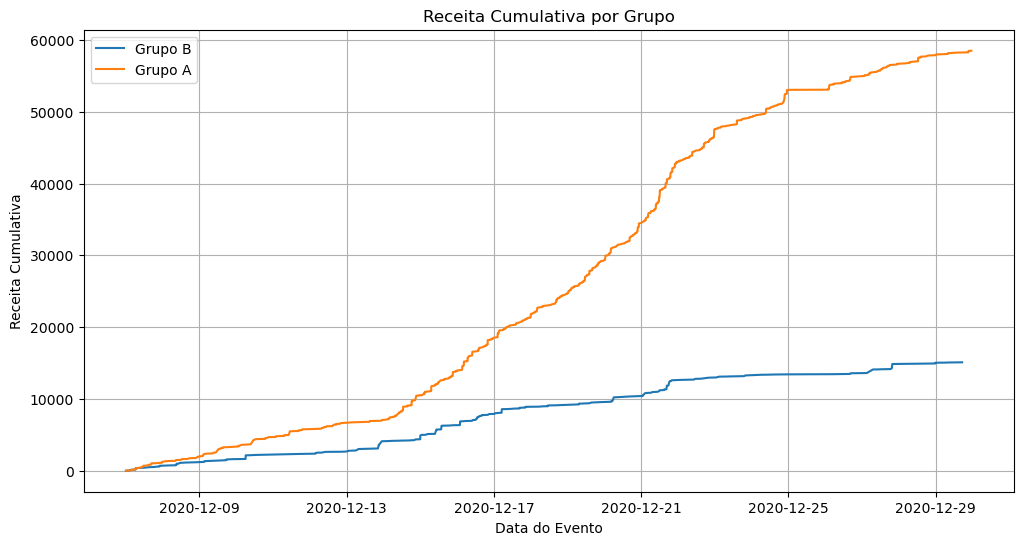

In [79]:
# plotando a receita cumulativa por grupo
plt.figure(figsize=(12, 6))
for group in user_purchases['group'].unique():
    group_data = user_purchases[user_purchases['group'] == group]
    plt.plot(group_data['event_dt'], group_data['cumulative_revenue'], label=f'Grupo {group}')

# configurando o gráfico
plt.title('Receita Cumulativa por Grupo')
plt.xlabel('Data do Evento')
plt.ylabel('Receita Cumulativa')
plt.legend()
plt.grid(True)
plt.show()

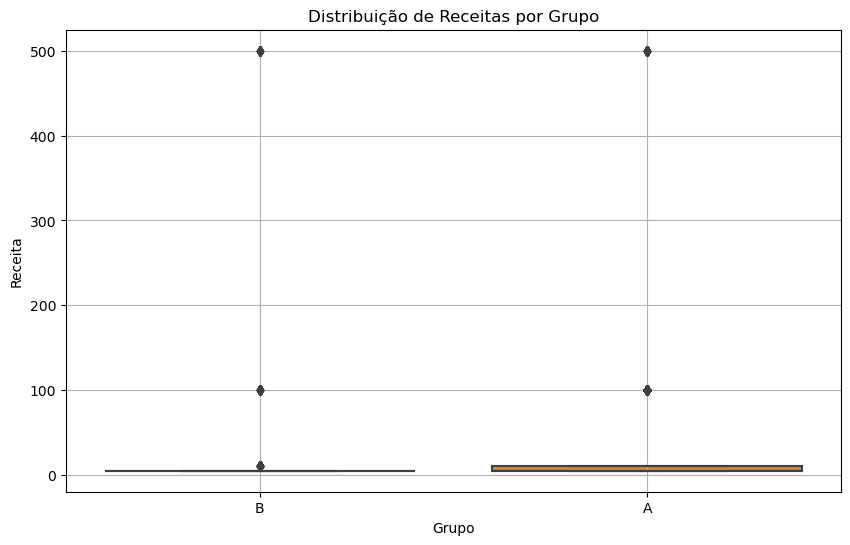

In [80]:
# plotando o boxplot da receita por usuário para cada grupo
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_purchases, x='group', y='details')
plt.title('Distribuição de Receitas por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Receita')
plt.grid(True)
plt.show()

**Anotações:**  
  
Receita Cumulativa por Grupo:

O gráfico mostra uma tendência de crescimento na receita cumulativa ao longo do tempo para os grupos A e B.  
O grupo A apresenta uma receita acumulada significativamente maior do que o grupo B, com um crescimento mais constante e rápido ao longo do período.  
O grupo B tem um crescimento mais lento e atinge um patamar consideravelmente mais baixo que o grupo A.    
O grupo A parece estar gerando mais receita ao longo do tempo.  
  
Boxplot da Distribuição de Receitas por Grupo:  
  
O boxplot revela que a maioria dos valores de receita para ambos os grupos está concentrada em valores baixos.  
Existem outliers em ambos os grupos, com receitas mais altas, mas essas são relativamente raras.  
A presença de outliers indica que alguns usuários podem estar realizando compras significativamente mais altas do que a média. No entanto, a receita típica (mediana) por usuário em ambos os grupos é relativamente baixa, e a distribuição das receitas parece ser bastante assimétrica devido à presença desses valores extremos.  

## 2. Avaliação do teste A/B

### 2.1. Z-test: Verificação da Diferença Estatística Entre as Proporções

In [81]:
conversion_rates

,Total Users,Product Page Viewers,Add to Cart,Purchasers,Product Page Conversion,Add to Cart Conversion,Purchase Conversion
group,,,,,,,
A,2747,1780,824,872,0.647980,0.462921,1.058252
B,928,523,255,256,0.563578,0.487572,1.003922


In [82]:
# número de usuários por grupo
total_users_A = conversion_rates.loc["A", "Total Users"]
total_users_B = conversion_rates.loc["B", "Total Users"]

# taxas de conversão por etapa para cada grupo
product_page_conv_A = conversion_rates.loc["A", "Product Page Conversion"]
product_page_conv_B = conversion_rates.loc["B", "Product Page Conversion"]

add_to_cart_conv_A = conversion_rates.loc["A", "Add to Cart Conversion"]
add_to_cart_conv_B = conversion_rates.loc["B", "Add to Cart Conversion"]

purchases_conv_A = conversion_rates.loc["A", "Purchase Conversion"]
purchases_conv_B = conversion_rates.loc["B", "Purchase Conversion"]


In [83]:
# função para calcular z e p-value para proporções
def z_test_proportion(p_A, p_B, n_A, n_B):
    # proporção combinada
    p_combined = (p_A * n_A + p_B * n_B) / (n_A + n_B)
    # verificação para evitar valores fora do domínio da raiz quadrada
    if p_combined * (1 - p_combined) * (1/n_A + 1/n_B) < 0:
        return None, None  # Retorna None se o cálculo for inválido
    # erro padrão
    standard_error = math.sqrt(p_combined * (1 - p_combined) * (1/n_A + 1/n_B))
    # estatística z
    z = (p_A - p_B) / standard_error
    # valor-p
    p_value = 2 * (1 - norm.cdf(abs(z)))  # teste bicaudal
    return z, p_value

In [84]:
# teste z para cada etapa de conversão
results = {
    "Product Page Conversion": z_test_proportion(product_page_conv_A, product_page_conv_B, total_users_A, total_users_B),
    "Add to Cart Conversion": z_test_proportion(add_to_cart_conv_A, add_to_cart_conv_B, total_users_A, total_users_B),
    "Purchase Conversion": z_test_proportion(purchases_conv_A, purchases_conv_B, total_users_A, total_users_B)
}

results

{'Product Page Conversion': (4.595797095745397, 4.310980554755872e-06),
 'Add to Cart Conversion': (-1.300936926601283, 0.1932800451163197),
 'Purchase Conversion': (None, None)}

**Resultados:**

**Product Page Conversion:**  
Estatística Z: 4.60  
Valor-p: 4.31e-06 (muito baixo, indicando uma diferença significativa entre os grupos A e B para esta métrica)  
  
**Add to Cart Conversion:**  
Estatística Z: -1.30  
Valor-p: 0.193 (não significativo, indicando que não há uma diferença estatisticamente significativa entre os grupos A e B para esta métrica)  
  
**Purchase Conversion:**  
Estatística Z e Valor-p: None  
O problema com o cálculo da conversão de compra pode estar relacionado ao fato de que os valores de purchases_conv_A e purchases_conv_B são maiores que 1 (1.058252 e 1.003922, respectivamente).

## 3. Conclusões

### 3.1.

#### 3.1.1. EDA

1. Participantes
- Verificou-se que 887 participantes participaram tanto do teste `recommender_system_test` (objeto de análise deste exercício) quanto do teste `interface_eu_test`.
- Se um mesmo usuário participa de dois testes ao mesmo tempo, ele pode ser exposto a diferentes variações que interferem nos resultados. Isso torna difícil isolar o impacto do sistema de recomendação melhorado, pois outros testes podem influenciar o comportamento do usuário.
- O número de usuários duplicados (887) corresponde a 0,24% do total de usuários participantes do teste (3675).
- Esperava-se a participação de 6000 usuários, mas o número total de participantes do teste foi de 3675.
- Verificou-se que usuários dos dois grupos participaram do teste.

2. Período do teste
- Verificou-se que os dados são compatíveis com o período de tempo delimitado para o teste.

3. Distribuição de eventos por usuário
- **Grupo A**: 6.780852
- **Grupo B**: 5.691810
- Após a realização do teste de Mann-Whitney U, verificou-se que há uma diferença estatisticamente significativa entre as médias dos grupos.
- Ambos os grupos (A e B) apresentam uma mediana similar no número de eventos por usuário, sugerindo que o comportamento médio entre os grupos é comparável.

3. Outliers
- Ambos os grupos possuem outliers, indicando usuários que realizaram um número significativamente maior de eventos em comparação com o restante dos participantes.
- O grupo B apresenta um número levemente maior de outliers com valores extremos.

4. Distribuição de eventos por dia
- **Tendência de Crescimento Inicial**: Observa-se que, a partir de 12 de dezembro de 2020, há um aumento notável no número de eventos diários. Esse crescimento se intensifica até atingir o pico em 20 de dezembro de 2020.
- **Pico de Eventos**: O dia 20 de dezembro de 2020 registra o maior número de eventos, com mais de 2000 ocorrências.
- **Declínio Gradual Após o Pico**: Após o pico em 20 de dezembro, há uma queda acentuada no número de eventos, que se torna mais constante e continua até o final do mês, em 30 de dezembro de 2020.
- **Estabilização e Finalização do Período de Alta**: A redução gradual ao longo dos últimos dias do período analisado sugere uma fase de estabilização, com os níveis de interação voltando aos patamares próximos dos observados no início do mês.
  
5. Receita Acumulada por Grupo

- **Grupo A** apresenta uma receita acumulada significativamente maior do que o **Grupo B** ao longo do período de análise. Observou-se um crescimento mais acelerado e constante na receita do Grupo A, o que sugere que os usuários desse grupo estão contribuindo com um volume financeiro superior.
- **Grupo B** exibe uma trajetória de receita acumulada mais lenta e atinge um patamar final muito inferior ao do Grupo A. Isso pode indicar uma menor propensão à geração de receita entre os usuários deste grupo, em comparação ao Grupo A.
- A diferença de receita entre os grupos é evidente e sugere que a variação de teste aplicada ao Grupo A pode estar gerando um efeito positivo em termos de monetização.
- No entanto, devido à presença de outliers (receitas excepcionalmente altas), é importante realizar uma análise complementar para verificar a robustez desse impacto. Os outliers podem estar influenciando a percepção de crescimento da receita, especialmente se forem poucos casos com valores muito elevados.
- As observações indicam que, em termos de receita, o **Grupo A** teve um desempenho superior ao **Grupo B** durante o período de teste. 


#### 3.1.2. Análise dos Resultados do Teste A/B

1. Objetivo e Critérios de Sucesso
O objetivo do teste era verificar se a introdução de um sistema de recomendação melhorado poderia aumentar a conversão nas etapas do funil de vendas (visualização de página do produto, adição ao carrinho e compras) em pelo menos 10% para cada métrica ao comparar o grupo de controle (A) com o grupo teste (B).

2. Resultados de Conversão
- **Product Page Conversion**: A conversão da página do produto foi significativamente maior no grupo A em relação ao grupo B, com um valor de \( z = 4.60 \) e \( p < 0.001 \). Esse resultado indica uma diferença estatisticamente significativa, mas na direção oposta ao esperado, ou seja, o grupo controle teve uma conversão melhor.
- **Add to Cart Conversion**: Não houve diferença estatisticamente significativa na taxa de conversão de adição ao carrinho entre os grupos, com um valor de \( z = -1.30 \) e \( p = 0.193 \). Assim, não foi detectado um aumento de 10% nessa etapa, como era esperado.
- **Purchase Conversion**: O cálculo para essa métrica resultou em valores inválidos, sugerindo que a proporção combinada e o erro padrão não puderam ser calculados corretamente. Isso pode indicar que a conversão no grupo A estava em um nível superior ao do grupo B, tornando a comparação instável.

3. Análise de Eventos por Usuário
O teste de Mann-Whitney U revelou uma diferença significativa no número médio de eventos por usuário entre os grupos A e B. O grupo A teve uma média maior de eventos por usuário em comparação ao grupo B. Isso indica que, em média, os usuários do grupo A interagiram mais vezes com o sistema.

4. Interpretação Geral
- O sistema de recomendação melhorado não atingiu o objetivo de aumentar as conversões nas etapas do funil em 10% para o grupo teste (B). Pelo contrário, o grupo controle (A) apresentou melhores resultados na visualização de páginas de produto, e não houve diferença significativa nas outras etapas.
- Esses resultados sugerem que a implementação do novo sistema de recomendação pode não ter trazido o benefício esperado para a conversão ou até mesmo pode ter impactado negativamente algumas métricas.

5. Conclusão  
Com base nesses achados, parece que o sistema de recomendação novo não teve o efeito desejado em melhorar a conversão dos usuários nas métricas analisadas. 


### 3.2. Conclusões gerais

**Análise do Período e Implicações no Teste**  
  
Ao observar o comportamento dos eventos ao longo dos dias do teste, especialmente o pico em 20 de dezembro de 2020 e o aumento constante a partir de 12 de dezembro, fica claro que o período analisado está inserido em uma época sazonal – o final do ano, que inclui as festas de Natal e Ano Novo. Esse período é conhecido por apresentar comportamentos atípicos, como aumento nas interações e nas compras, devido a promoções, campanhas específicas e ao hábito dos consumidores de fazerem mais compras no fim do ano.

Realizar um teste A/B durante um período sazonal pode comprometer a validade dos resultados, pois os comportamentos dos usuários tendem a ser influenciados por fatores externos específicos desse período, como a maior propensão a comprar presentes ou aproveitar descontos sazonais. Esse comportamento pode impactar as métricas de conversão, especialmente na etapa de compras, uma vez que o aumento nas transações pode não refletir diretamente a eficácia de um novo sistema de recomendação, mas sim uma maior predisposição natural dos usuários a comprar.

Ao testar novas funcionalidades nesse período, é difícil discernir se os aumentos ou mudanças nas métricas de conversão resultam diretamente das modificações introduzidas (neste caso, o sistema de recomendação) ou de uma tendência sazonal. Portanto, os resultados de um teste realizado em um período sazonal podem não ser representativos do comportamento dos usuários em outros momentos do ano, limitando a aplicabilidade das conclusões.

Conduzir o teste de conversão no mês de dezembro pode não ter sido uma escolha ideal para avaliar com precisão o impacto do novo sistema de recomendação. Para reduzir o viés sazonal, seria mais recomendável realizar o teste em um período de menor variação comportamental ou, alternativamente, considerar uma extensão do período de coleta de dados para incluir um intervalo temporal mais equilibrado.
  
  
**Impacto da Interseção de Usuários nos Resultados**  
  
A interseção de 887 usuários que participaram simultaneamente do teste `interface_eu_test` e do teste `recommender_system_test` também afeta os resultados, pois esses usuários podem ter sido expostos a múltiplas variáveis simultâneas, dificultando o isolamento do efeito do sistema de recomendação. Esse viés torna menos preciso o entendimento do impacto da nova recomendação, dado que alterações na interface poderiam ter influenciado tanto o comportamento de navegação quanto a decisão de compra dos usuários.